In [2]:
#import libraries
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from scipy.special import softmax

In [2]:
dirs = os.listdir('data')
imgs_path = []
labels = []
for i in dirs:
    image_path = glob('./data/{}/*.png'.format(i))
    label =['{}'.format(i)]*len(image_path)
    # append
    imgs_path.extend(image_path)
    labels.extend(label)

In [3]:
print(imgs_path[0],'\n',labels[0])

./data/Mask\10.png 
 Mask


In [4]:
# face detection
face_detection_model = cv2.dnn.readNetFromCaffe('./models/deploy.prototxt.txt',
                                                './models/res10_300x300_ssd_iter_140000_fp16.caffemodel')

In [5]:
def face_detection_dnn(img):
    # blob from image 
    image = img.copy()
    h,w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True)
   
    face_detection_model.setInput(blob)
    detections = face_detection_model.forward()
    for i in range(0,detections.shape[2]):
        confidence_score = detections[0,0,i,2] 
        if confidence_score > 0.5:
            box = detections[0,0,i,3:7]*np.array([w,h,w,h])
            box = box.astype(int)  
            pt1 = (box[0],box[1])
            pt2 = (box[2],box[3])
            roi = image[box[1]:box[3],box[0]:box[2]]
            return roi
    return None      

In [6]:
img = cv2.imread(imgs_path[1])
img_roi = face_detection_dnn(img)

In [7]:
cv2.imshow('roi',img_roi)
cv2.imshow('original',img)
cv2.waitKey()
cv2.destroyAllWindows()

In [8]:
def data_preprocess(img):
    # blob from image 
    face = face_detection_dnn(img)
    if face is not None:

        # computing blob from image
        blob = cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
        blob_squeeze = np.squeeze(blob).T
        blob_rotate = cv2.rotate(blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
        blob_flip = cv2.flip(blob_rotate,1)
        # remove negative values and normalize
        img_normd = np.maximum(blob_flip,0)/blob_flip.max()
    
        return img_normd
    else:
        return None

In [9]:
from tqdm import tqdm
import gc

data_img = []
label_img = []
i = 0
for path, label in tqdm(zip(imgs_path,labels),desc='preprocessing'):
    img = cv2.imread(path)
    process_img = data_preprocess(img)
    if process_img is not None:
        data_img.append(process_img)
        label_img.append(label)
          
    i += 1
    if i%100 == 0:
        gc.collect()

preprocessing: 11792it [10:55, 17.99it/s]


In [10]:
X = np.array(data_img)
y = np.array(label_img)

In [11]:
np.savez('./data/data_preprocess.npz',X,y)

In [3]:
# load preprocessed data
data = np.load('./data/data_preprocess.npz')

In [4]:
X = data['arr_0'] #images
y = data['arr_1'] #labels

In [5]:
np.unique(y)

array(['Mask', 'No Mask'], dtype='<U7')

In [6]:
#feature engineering
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder()
y_onehot = onehot.fit_transform(y.reshape(-1,1))
y_array = y_onehot.toarray()

In [7]:
#Splitting the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y_array,test_size=0.2)

In [8]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8773, 100, 100, 3), (2194, 100, 100, 3), (8773, 2), (2194, 2))

In [10]:
# convolution neural network

model = Sequential([
    layers.Conv2D(16,3,padding='same',input_shape=(100,100,3),activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(192,activation='relu'),
    layers.Dense(28,activation='relu'),
    layers.Dense(2,activation='sigmoid')
])


# compiling CNN
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [11]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Training CNN
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test,y_test),
                    epochs=20,
                    verbose =1)

Epoch 1/20
274/275 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9557INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


275/275 [==============================] - 153s 534ms/step - loss: 0.1137 - accuracy: 0.9558 - val_loss: 0.1206 - val_accuracy: 0.9549
Epoch 2/20
274/275 [============================>.] - ETA: 0s - loss: 0.0537 - accuracy: 0.9807INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


275/275 [==============================] - 73s 267ms/step - loss: 0.0537 - accuracy: 0.9807 - val_loss: 0.0425 - val_accuracy: 0.9854
Epoch 3/20
275/275 [==============================] - 58s 210ms/step - loss: 0.0338 - accuracy: 0.9886 - val_loss: 0.1182 - val_accuracy: 0.9631
Epoch 4/20
275/275 [==============================] - 64s 234ms/step - loss: 0.0288 - accuracy: 0.9891 - val_loss: 0.0465 - val_accuracy: 0.9850
Epoch 5/20
275/275 [==============================] - 61s 221ms/step - loss: 0.0209 - accuracy: 0.9926 - val_loss: 0.0438 - val_accuracy: 0.9845
Epoch 6/20
275/275 [==============================] - ETA: 0s - loss: 0.0113 - accuracy: 0.9956INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


275/275 [==============================] - 60s 218ms/step - loss: 0.0113 - accuracy: 0.9956 - val_loss: 0.0382 - val_accuracy: 0.9877
Epoch 7/20
275/275 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9966INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


275/275 [==============================] - 67s 245ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0353 - val_accuracy: 0.9886
Epoch 8/20
275/275 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9965INFO:tensorflow:Assets written to: .\assets


INFO:tensorflow:Assets written to: .\assets


275/275 [==============================] - 71s 259ms/step - loss: 0.0089 - accuracy: 0.9965 - val_loss: 0.0244 - val_accuracy: 0.9918
Epoch 9/20
275/275 [==============================] - 62s 227ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0318 - val_accuracy: 0.9900
Epoch 10/20
275/275 [==============================] - 62s 225ms/step - loss: 0.0123 - accuracy: 0.9964 - val_loss: 0.0350 - val_accuracy: 0.9881
Epoch 11/20
275/275 [==============================] - 62s 226ms/step - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0335 - val_accuracy: 0.9891
Epoch 12/20
275/275 [==============================] - 62s 227ms/step - loss: 0.0060 - accuracy: 0.9981 - val_loss: 0.0423 - val_accuracy: 0.9868
Epoch 13/20
275/275 [==============================] - 62s 227ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0442 - val_accuracy: 0.9895
Epoch 14/20
275/275 [==============================] - 65s 237ms/step - loss: 0.0114 - accuracy: 0.9970 - val_loss: 0.0748 - val_accuracy

In [13]:
# Save the Model
model.save('face_cnn_model')

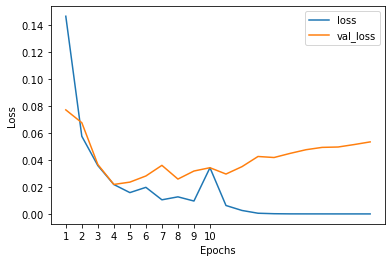

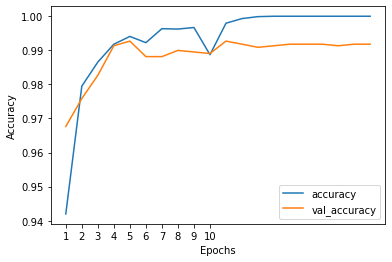

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

history_df

history_df[['loss','val_loss']].plot(kind='line')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(list(range(10)),list(range(1,11)))
plt.show()

history_df[['accuracy','val_accuracy']].plot(kind='line')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(list(range(10)),list(range(1,11)))
plt.show()

In [24]:
# face detection model
face_detection_model = cv2.dnn.readNetFromCaffe('./models/deploy.prototxt.txt',
                                                './models/res10_300x300_ssd_iter_140000_fp16.caffemodel')
# face mask recognition model
model = tf.keras.models.load_model('face_cnn_model/')

In [25]:
# label 
labels = ['Mask', 'No Mask']


def getColor(label):
    if label == "Mask":
        color = (0,255,0)

    elif label == 'No Mask':
        color = (0,0,255)
        
    return color

In [29]:
def face_mask_prediction(img):
    # step - 1 : face detection
    image = img.copy()
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image,1,(300,300),(104,117,123),swapRB=True)
    # 
    face_detection_model.setInput(blob)
    detection = face_detection_model.forward() # it will give the detection
    for i in range(0,detection.shape[2]):
        confidence = detection[0,0,i,2]
        if confidence > 0.5:
            box = detection[0,0,i,3:7]*np.array([w,h,w,h])
            box = box.astype(int)
            pt1 = (box[0], box[1])
            pt2 = (box[2], box[3])
            # cv2.rectangle(image,pt1,pt2,(0,255,0),1)

            # step -2: Data preprocessing
            face = image[box[1]:box[3],box[0]:box[2]]
            face_blob = cv2.dnn.blobFromImage(face,1,(100,100),(104,117,123),swapRB=True)
            face_blob_squeeze = np.squeeze(face_blob).T
            face_blob_rotate = cv2.rotate(face_blob_squeeze,cv2.ROTATE_90_CLOCKWISE)
            face_blob_flip = cv2.flip(face_blob_rotate,1)
            # normalization
            img_norm = np.maximum(face_blob_flip,0)/face_blob_flip.max()
            # step-3: Deep Learning (CNN)
            img_input = img_norm.reshape(1,100,100,3)
            result = model.predict(img_input)
            result = softmax(result)[0]
            confidence_index = result.argmax()
            confidence_score = result[confidence_index]
            label = labels[confidence_index]
            label_text = '{}: {:,.0f} %'.format(label,confidence_score*100)
            #print(label_text)
            # color
            color = getColor(label)
            cv2.rectangle(image,pt1,pt2,color,3)
            cv2.putText(image,label_text,pt1,cv2.FONT_HERSHEY_PLAIN,2,color,2)
            
    return image

In [ ]:
#Live Face Mask Detection
cap = cv2.VideoCapture(0)

while True:
    ret, frames = cap.read()
    if ret == False:
        break
        
    image = face_mask_prediction(frames)
    cv2.imshow('Face Mask Prediction',image)
    if cv2.waitKey(1) == 27:
        break
        
cap.release()
cv2.destroyAllWindows()